In [1]:
import sys
sys.path.insert(1, '../FeatureEngineering')

import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dropout, Input
import matplotlib.pyplot as plt
from util import plot_history
import util
import feature_builder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

Cargo datasets

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Armo features con el feature_builder

In [3]:
def prepare_for_cnn(df):
    processed = feature_builder.process_dataset(
        df,
        encoding_type='binary',
        text_type='embeddings',
        use_manual_features=False,
        use_spacy=True
    )
    to_numpy = processed.to_numpy()
    to_numpy = to_numpy.reshape(processed.shape[0], processed.shape[1], 1)
    return processed, to_numpy

In [4]:
%%time
processed, train = prepare_for_cnn(train_df)
train_target = train_df['target'].values

Embeddings loaded!
Percentage of words covered in the embeddings = 0.6336399642263958
Embeddings loaded!
Percentage of words covered in the embeddings = 0.5961027457927369
Wall time: 2min 8s


In [5]:
processed

,spacy_text_embedding_0,spacy_text_embedding_1,spacy_text_embedding_2,spacy_text_embedding_3,spacy_text_embedding_4,spacy_text_embedding_5,spacy_text_embedding_6,spacy_text_embedding_7,spacy_text_embedding_8,spacy_text_embedding_9,...,text_embedding_298,text_embedding_299,c0,c1,c2,c3,c4,c5,c6,c7
0,0.157756,0.075226,0.187012,0.126872,-0.039958,0.071513,0.184001,-0.030090,0.252848,0.202311,...,-0.020348,0.119019,0,0,0,0,0,0,0,0
1,0.055664,0.024200,-0.009262,0.085653,0.135091,0.004150,0.015259,-0.083923,-0.040029,0.008097,...,0.050014,0.039224,0,0,0,0,0,0,0,0
2,0.000875,0.013479,0.084412,-0.038966,-0.056183,-0.086884,0.025266,-0.009633,0.074320,0.000315,...,0.019644,-0.015137,0,0,0,0,0,0,0,0
3,0.172323,-0.095561,0.014506,0.212870,0.025777,-0.078011,-0.059733,-0.028809,0.003270,0.085978,...,-0.026367,-0.033366,0,0,0,0,0,0,0,0
4,0.067763,0.029093,-0.065877,0.077454,-0.015055,0.008104,0.022624,-0.162896,-0.033847,0.147298,...,0.030786,0.031708,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,-0.032426,0.038549,-0.042503,0.041681,-0.027800,-0.032171,0.023923,-0.042744,0.169267,0.021212,...,-0.001657,-0.127274,0,0,0,0,0,0,0,0
7609,0.121609,0.031860,0.005450,0.029224,-0.004327,-0.073621,0.097827,-0.072827,-0.009570,0.133057,...,0.039574,-0.020186,0,0,0,0,0,0,0,0
7610,-0.067261,-0.031845,0.073174,0.130371,-0.019745,-0.018089,-0.091187,-0.173370,0.057335,0.054550,...,0.089233,0.258301,0,0,0,0,0,0,0,0
7611,0.029703,0.041425,0.031236,-0.016243,-0.043529,0.013047,0.048455,-0.075612,0.010319,0.097200,...,0.018721,-0.048802,0,0,0,0,0,0,0,0


In [6]:
X_train, X_pred, y_train, y_pred = train_test_split(train, train_target, test_size=0.33, random_state=42)

In [7]:
X_train.shape

(5100, 608, 1)

In [8]:
X_pred.shape

(2513, 608, 1)

Creo el modelo y corro la CNN

In [9]:
def create_model(filters, kernel_sizes, pool_sizes, units, cnn_layers, dense_layers):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    
    for i in range(cnn_layers):
        model.add(Conv1D(filters=filters[i], kernel_size=kernel_sizes[i], activation='relu'))
    model.add(MaxPooling1D(2))#pool_sizes[i]))

    model.add(Flatten())
    
    for i in range(dense_layers):
        model.add(Dense(units[i], activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-4), metrics=['accuracy'])
    return model

In [10]:
filters=[32,32,64]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[64]
cnn_layers=3
dense_layers=1

In [11]:
filters=[64]
kernel_size=[3]
pool_sizes=[2]
units=[32]
cnn_layers=1
dense_layers=1

In [12]:
#acc = 0.8
filters=[128,128]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[32, 32]
cnn_layers=2
dense_layers=2

In [13]:
#acc = 0.80 cleaner
filters=[128,128,128]
kernel_size=[3,4,5]
pool_sizes=[2,2,2]
units=[64,64,64]
cnn_layers=3
dense_layers=3

Epoch 1/12
160/160 [==============================] - 29s 183ms/step - loss: 0.6545 - accuracy: 0.6080 - val_loss: 0.5267 - val_accuracy: 0.7935
Epoch 2/12
160/160 [==============================] - 31s 196ms/step - loss: 0.5178 - accuracy: 0.7661 - val_loss: 0.4597 - val_accuracy: 0.8102
Epoch 3/12
160/160 [==============================] - 29s 179ms/step - loss: 0.4759 - accuracy: 0.7912 - val_loss: 0.4331 - val_accuracy: 0.8177
Epoch 4/12
160/160 [==============================] - 28s 173ms/step - loss: 0.4581 - accuracy: 0.8063 - val_loss: 0.4241 - val_accuracy: 0.8225
Epoch 5/12
160/160 [==============================] - 28s 177ms/step - loss: 0.4392 - accuracy: 0.8157 - val_loss: 0.4177 - val_accuracy: 0.8245
Epoch 6/12
160/160 [==============================] - 28s 175ms/step - loss: 0.4223 - accuracy: 0.8188 - val_loss: 0.4137 - val_accuracy: 0.8253
Epoch 7/12
160/160 [==============================] - 28s 176ms/step - loss: 0.4103 - accuracy: 0.8290 - val_loss: 0.4133 - val_ac

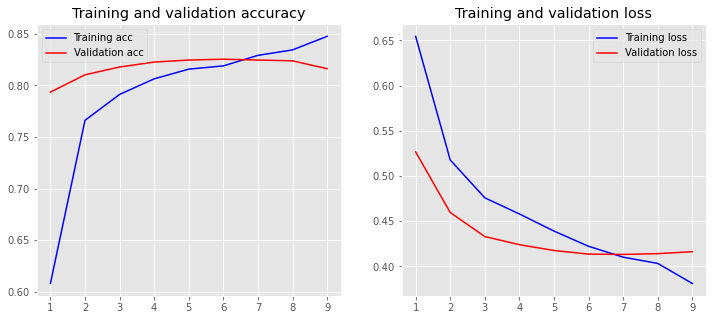

In [15]:
model = create_model(
    filters=filters,
    kernel_sizes=kernel_size,
    pool_sizes=pool_sizes,
    units=units,
    cnn_layers=cnn_layers,
    dense_layers=dense_layers
)
es = keras.callbacks.EarlyStopping(patience=2)
history = model.fit(X_train, y_train, epochs=12, shuffle=False, validation_data=(X_pred, y_pred), callbacks=[es])#, batch_size=16)
plot_history(history)

Calculemos el test para kaggle

In [16]:
prediction = model.predict_classes(X_pred)
f1 = f1_score(y_pred, [x[0] for x in prediction])
print(f'F1 Score: {f1}')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
F1 Score: 0.769


In [32]:
ids = test_df['id']

processed, final_test = prepare_for_cnn(test_df)
prediction = model.predict_classes(final_test)

final_df = pd.DataFrame({'target': [x[0] for x in prediction]}, index=ids)
final_df

Percentage of words covered in the embeddings = 0.5707598689343111
Percentage of words covered in the embeddings = 0.665389037945573


,target
id,
0,1
2,0
3,1
9,1
11,1
...,...
10861,0
10865,1
10868,1


In [33]:
final_df['target'].value_counts()

0    2342
1     921
Name: target, dtype: int64

In [34]:
final_df.count()

target    3263
dtype: int64

In [35]:
final_df.to_csv('cnn_loc.csv')